Accuracy: 99.60%


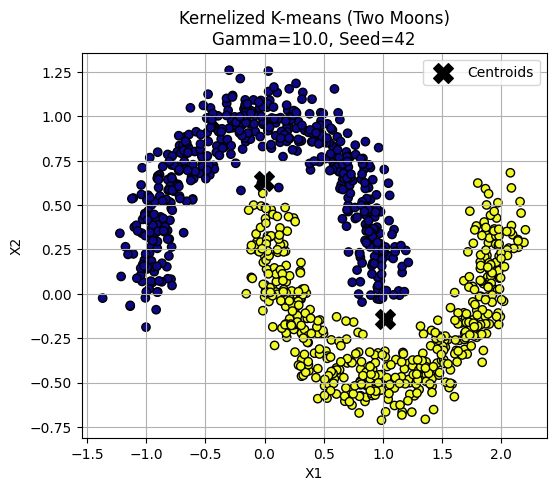

In [9]:
# import numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt


# make file for saving parameters
save_path = "my_saved_results/"


# define RBF kernel function
def rbf_kernel(X_data, gamma=10.0):
    sq_dists = np.sum((X_data[:, np.newaxis] - X_data[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * sq_dists)


# define kernel k-means class
class KMeans_Kernel:
    def __init__(self, n_clusters=2, iteration=100, gamma=10.0, seed=42):
        self.n_clusters = n_clusters
        self.iteration = iteration
        self.gamma = gamma
        self.seed = seed

    def training(self, X_data):
        self.X_original = X_data.copy()
        n_samples = X_data.shape[0]
        self.K_matrix = rbf_kernel(X_data, gamma=self.gamma)
        rng = np.random.default_rng(self.seed)
        self.labels_ = rng.integers(0, self.n_clusters, size=n_samples)

        for _ in range(self.iteration):
            self.clusters_ = [np.where(self.labels_ == i)[0] for i in range(self.n_clusters)]
            dist = np.zeros((n_samples, self.n_clusters))
            for i in range(self.n_clusters):
                if len(self.clusters_[i]) == 0:
                    continue
                K_cc = self.K_matrix[np.ix_(self.clusters_[i], self.clusters_[i])]
                K_ic = self.K_matrix[:, self.clusters_[i]]
                N_c = len(self.clusters_[i])
                dist[:, i] = (
                    self.K_matrix.diagonal()
                    - (2 / N_c) * np.sum(K_ic, axis=1)
                    + (1 / N_c**2) * np.sum(K_cc)
                )
            new_labels = np.argmin(dist, axis=1)
            if np.all(new_labels == self.labels_):
                break
            self.labels_ = new_labels

        # centroid (original space)
        self.centroids_ = np.array([
            self.X_original[self.labels_ == i].mean(axis=0)
            for i in range(self.n_clusters)
        ])

    def predict(self):
        return self.labels_

    def get_centroids(self):
        return self.centroids_

    def get_kernel_matrix(self):
        return self.K_matrix


# accuracy function
def check_clustering_accuracy(y_true, y_pred):
    return max(np.mean(y_true == y_pred), np.mean(y_true != y_pred))


# data
X_data = np.loadtxt("dataX.txt")
y_true = np.loadtxt("dataY.txt").astype(int)


# training
gamma = 10.0
seed = 42
k_model = KMeans_Kernel(n_clusters=2, iteration=100, gamma=gamma, seed=seed)
k_model.training(X_data)
cluster_labels = k_model.predict()


# accuracy
accuracy = check_clustering_accuracy(y_true, cluster_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


# save parameters
np.save(save_path + "best_centroids_original.npy", k_model.get_centroids())
np.save(save_path + "best_cluster_labels.npy", cluster_labels)
np.save(save_path + "best_kernel_matrix.npy", k_model.get_kernel_matrix())
np.save(save_path + "best_gamma_seed.npy", np.array([gamma, seed]))


# visualization
plt.figure(figsize=(6, 5))
plt.scatter(X_data[:, 0], X_data[:, 1], c=cluster_labels, cmap="plasma", edgecolors='k')
plt.scatter(*k_model.get_centroids().T, s=200, marker='X', c='black', label="Centroids")
plt.title(f"Two Moons (Kernelized K-means)\nGamma={gamma}, Seed={seed}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()
plt.show()

